In [3]:
# !pip install tensorflow==2.9.0
# !pip install ampligraph
# !pip install pandas
# !pip install numpy
# !pip install adjustText
# !pip install seaborn

You should consider upgrading via the 'C:\Users\wgmlg\.pyenv\pyenv-win\versions\3.9.7\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\wgmlg\.pyenv\pyenv-win\versions\3.9.7\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\wgmlg\.pyenv\pyenv-win\versions\3.9.7\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\wgmlg\.pyenv\pyenv-win\versions\3.9.7\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\wgmlg\.pyenv\pyenv-win\versions\3.9.7\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\wgmlg\.pyenv\pyenv-win\versions\3.9.7\python.exe -m pip install --upgrade pip' command.


In [35]:
import numpy as np
import pandas as pd
import tensorflow as tf
import ampligraph

In [161]:
df = pd.read_csv("authors_fixed.csv")

In [162]:
df.isna().sum()

Unnamed: 0                          0
authorLabel                         0
combinedGenres                      0
birthDate                           0
combinedNationalityOrLanguage    1115
topBooks                            0
author_id                           0
genres_list                         0
books_list                          0
dtype: int64

In [175]:
import re

def split_and_clean(s):
    if pd.isna(s):
        return []
    items = []
    for item in s.split(","):
        items.extend(item.split("\n"))
    clean_items = [re.sub(r'[^a-zA-Z0-9 ]', '', x.strip()).strip().title() for x in items if x.strip()]
    return clean_items

# Entities naming
df["author_id"] = df['authorLabel'].values.astype(str)
# df["match_id"] =  "Match" + df.match_id
df['genres_list'] = df['combinedGenres'].apply(split_and_clean)
df['books_list'] = df['topBooks'].apply(split_and_clean)


df = df.drop_duplicates(subset=['author_id'])
# df["city_id"] = "City" + df.city.str.title().str.replace(" ", "")
# df["country_id"] = "Country" + df.country.str.title().str.replace(" ", "")
# df["home_team_id"] = "Team" + df.home_team.str.title().str.replace(" ", "")
# df["away_team_id"] = "Team" + df.away_team.str.title().str.replace(" ", "")
# df["tournament_id"] = "Tournament" + df.tournament.str.title().str.replace(" ", "")
# df["neutral"] = df.neutral.astype(str)

df.to_csv('authors_fixed.csv')

df

,Unnamed: 0,authorLabel,combinedGenres,birthDate,combinedNationalityOrLanguage,topBooks,author_id,genres_list,books_list
0,0,A. A. Milne,Children's literature,1882-01-18,NaN,Winnie-the-Pooh,A. A. Milne,[Childrens Literature],[Winniethepooh]
1,1,A. E. Housman,Lyric poetry,1859-03-26,NaN,A Shropshire Lad,A. E. Housman,[Lyric Poetry],[A Shropshire Lad]
2,2,A. Igoni Barrett,"Short stories, novels",1979-03-26,English,Blackass,A. Igoni Barrett,"[Short Stories, Novels]",[Blackass]
3,3,A. J. Healy,"Comedy, Fantasy",1969-04-02,Ireland,"Tommy Storm, Tommy Storm and the Galactic Knights",A. J. Healy,"[Comedy, Fantasy]","[Tommy Storm, Tommy Storm And The Galactic Kni..."
4,4,A. J. Quinnell,Thriller fiction,1940-06-25,NaN,"Man on Fire (Quinnell novel), The Mahdi",A. J. Quinnell,[Thriller Fiction],"[Man On Fire Quinnell Novel, The Mahdi]"
...,...,...,...,...,...,...,...,...,...
1624,1664,Álvares de Azevedo,"Essay, Poetry, Theatre",1831-09-12,Portuguese language,"Lira dos Vinte Anos, Noite na Taverna",Álvares de Azevedo,"[Essay, Poetry, Theatre]","[Lira Dos Vinte Anos, Noite Na Taverna]"
1625,1665,Álvaro Mutis,Fiction,1923-08-25,NaN,The Adventures and Misadventures of Maqroll,Álvaro Mutis,[Fiction],[The Adventures And Misadventures Of Maqroll]
1626,1666,Åke Holmberg,Children's literature,1907-05-31,Swedish language,Tam Sventon,Åke Holmberg,[Childrens Literature],[Tam Sventon]
1627,1667,Élisabeth Vonarburg,"Fantasy, Historical",1947-08-05,NaN,Chroniques du Pays des Mères,Élisabeth Vonarburg,"[Fantasy, Historical]",[Chroniques Du Pays Des Mres]


In [350]:
triples = []

for _, row in df.iterrows():
    # Handle multiple books
    for book in row["books_list"]:
        book_id = "Book" + book.replace(" ", "_")
        author_book = (row["author_id"], "wrote", book_id)
        triples.append(author_book)

    # Handle multiple genres from the list
    for genre in row["genres_list"]:
        genre_id = "Genre" + genre.replace(" ", "_")
        author_genre = (row["author_id"], "writesGenre", genre_id)
        triples.append(author_genre)
    
    # Birthdate and nationality information
    if pd.notna(row["birthDate"]):
        # birth_date = (row["author_id"], "bornOn", row["birthDate"])
        
        year = int(row["birthDate"][:4])  # Extract the year as integer
        century = (year // 100) + 1        # E.g., 1882 -> 1880
        decade_id = f"Century_{century}"
        birth_date_triple = (row["author_id"], "bornInCentury", decade_id)
        triples.append(birth_date_triple)

        # triples.append(birth_date)
    
    # if pd.notna(row["combinedNationalityOrLanguage"]):
    #     nationality = (row["author_id"], "hasNationality", "Language" + row["combinedNationalityOrLanguage"].replace(" ", "_"))
    #     triples.append(nationality)


# Display the first few triples to check the structure
triples[:10]


[('A. A. Milne', 'wrote', 'BookWinniethepooh'),
 ('A. A. Milne', 'writesGenre', 'GenreChildrens_Literature'),
 ('A. A. Milne', 'bornInCentury', 'Century_19'),
 ('A. E. Housman', 'wrote', 'BookA_Shropshire_Lad'),
 ('A. E. Housman', 'writesGenre', 'GenreLyric_Poetry'),
 ('A. E. Housman', 'bornInCentury', 'Century_19'),
 ('A. Igoni Barrett', 'wrote', 'BookBlackass'),
 ('A. Igoni Barrett', 'writesGenre', 'GenreShort_Stories'),
 ('A. Igoni Barrett', 'writesGenre', 'GenreNovels'),
 ('A. Igoni Barrett', 'bornInCentury', 'Century_20')]

In [351]:
triples_df = pd.DataFrame(triples, columns=["subject", "predicate", "object"])
triples_df[(triples_df.subject=="Fyodor Dostoevsky") | (triples_df.subject=="Alexander Pushkin")]

triples_df.to_csv('tri.csv')

In [352]:
from ampligraph.evaluation import train_test_split_no_unseen

X_train, X_valid = train_test_split_no_unseen(np.array(triples), test_size=500)
print('Train set size: ', X_train.shape)
print('Test set size: ', X_valid.shape)

Train set size:  (7679, 3)
Test set size:  (500, 3)


In [353]:
from ampligraph.latent_features import ScoringBasedEmbeddingModel
from ampligraph.latent_features.loss_functions import get as get_loss
from ampligraph.latent_features.regularizers import get as get_regularizer

model = ScoringBasedEmbeddingModel(k=100,
                                   eta=30,
                                   scoring_type='ComplEx',
                                   seed=0)

# Optimizer, loss and regularizer definition
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
loss = get_loss('multiclass_nll')
regularizer = get_regularizer('LP', {'p': 3, 'lambda': 1e-6})

# Compilation of the model
model.compile(optimizer=optimizer, loss=loss, entity_relation_regularizer=regularizer)

In [354]:
model.fit(X_train,
          batch_size=int(512),
          epochs=300, # Number of training epochs
          verbose=True # Displays a progress bar.
          )

Epoch 1/300
16/16 [==============================] - 1s 48ms/step - loss: 1757.6619
Epoch 2/300
16/16 [==============================] - 0s 23ms/step - loss: 1733.6774
Epoch 3/300
16/16 [==============================] - 0s 24ms/step - loss: 1606.8289
Epoch 4/300
16/16 [==============================] - 0s 24ms/step - loss: 1340.9243
Epoch 5/300
16/16 [==============================] - 0s 25ms/step - loss: 1114.5222
Epoch 6/300
16/16 [==============================] - 0s 23ms/step - loss: 960.7776
Epoch 7/300
16/16 [==============================] - 0s 23ms/step - loss: 850.2793
Epoch 8/300
16/16 [==============================] - 0s 23ms/step - loss: 766.5165
Epoch 9/300
16/16 [==============================] - 0s 25ms/step - loss: 701.2667
Epoch 10/300
16/16 [==============================] - 0s 23ms/step - loss: 649.2872
Epoch 11/300
16/16 [==============================] - 0s 24ms/step - loss: 606.1114
Epoch 12/300
16/16 [==============================] - 0s 23ms/step - loss: 570.0

In [355]:
ranks = model.evaluate(X_valid,
                      use_filter={'train': X_train,
                                  'test': X_valid},
                      corrupt_side='s,o',
                      verbose=True)

51/51 [==============================] - 1s 18ms/step


In [356]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

fixed_ranks = []
for rank in ranks:
    if rank[0] != 0 and rank[1] != 0:
        fixed_ranks.append(rank)

ranks = np.array(fixed_ranks)

mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.04
MR: 726.86
Hits@10: 0.09
Hits@3: 0.03
Hits@1: 0.01


In [357]:
for i in ranks:
  print(i)

[1385  542]
[2404 3409]
[192  13]
[ 331 1902]
[ 326 1561]
[769  50]
[332 893]
[761 127]
[ 80 141]
[271   6]
[5 8]
[ 936 1079]
[ 325 1513]
[427  18]
[1776 5454]
[  53 1884]
[1225  374]
[ 8 11]
[292  23]
[ 275 1382]
[69 13]
[ 611 1014]
[171  32]
[238 242]
[262  72]
[3086 4203]
[ 335 1097]
[604 867]
[ 446 2184]
[1384   99]
[230  32]
[197   6]
[2610 1647]
[249   8]
[ 732 2331]
[1115  188]
[1177  274]
[346 103]
[  30 1238]
[163  19]
[200  20]
[ 11 356]
[1233 1909]
[553  84]
[954 131]
[  54 1213]
[1945 1874]
[2142 1511]
[350  65]
[ 257 1030]
[ 881 3597]
[1196  109]
[527  68]
[2491 2181]
[262 257]
[1206 1786]
[ 204 1249]
[184  19]
[84  3]
[454  20]
[ 55 114]
[ 35 596]
[301  22]
[256 112]
[ 266 1337]
[1011  116]
[ 35 579]
[1251  349]
[139 264]
[12 39]
[859 165]
[3001 2248]
[497 342]
[1280  674]
[1231  677]
[729 111]
[293 648]
[62  4]
[1123  255]
[451  31]
[ 301 1227]
[1159  174]
[ 54 455]
[1121  142]
[ 237 1441]
[9 3]
[39  4]
[1130  234]
[21  1]
[22 86]
[ 240 1082]
[834  64]
[ 485 1634]
[ 125 

In [358]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
%matplotlib inline

In [359]:
authors = df['author_id']
authors_embeddings = dict(zip(authors, model.get_embeddings(authors)))
len(authors_embeddings)
len(authors)

1629

In [360]:
embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in authors_embeddings.values()]))

In [361]:
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans

clustering_algorithm = KMeans(n_clusters=6, n_init=50, max_iter=500, random_state=0)
clusters = find_clusters(authors, model, clustering_algorithm, mode='e')

In [362]:
print(len(embeddings_2d))
print(len(authors))
plot_df = pd.DataFrame({"authors": authors,
                        "birthDate": df['birthDate'],
                        "embedding1": embeddings_2d[:, 0],
                        "embedding2": embeddings_2d[:, 1],
                        "cluster": "cluster" + pd.Series(clusters).astype(str)
                        }
                       )
plot_df

1629
1629


,authors,birthDate,embedding1,embedding2,cluster
0,A. A. Milne,1882-01-18,-4.674438,1.417658,cluster1
1,A. E. Housman,1859-03-26,-4.861589,1.266885,cluster1
2,A. Igoni Barrett,1979-03-26,1.012894,0.442278,cluster0
3,A. J. Healy,1969-04-02,-2.205894,-3.106796,cluster3
4,A. J. Quinnell,1940-06-25,1.977667,0.865104,cluster0
...,...,...,...,...,...
1624,Álvares de Azevedo,1831-09-12,-4.766496,1.572072,cluster1
1625,Álvaro Mutis,1923-08-25,0.795864,1.124645,cluster4
1626,Åke Holmberg,1907-05-31,0.358514,1.114140,cluster2
1627,Élisabeth Vonarburg,1947-08-05,0.679674,-2.074504,cluster3


In [363]:
show_authors = ['Alexander Pushkin', 'Fyodor Dostoevsky', 'Arthur Conan Doyle']
def plot_clusters(hue):
    np.random.seed(0)
    plt.figure(figsize=(12, 12))
    plt.title("{} embeddings".format(hue).capitalize())
    ax = sns.scatterplot(data=plot_df, x="embedding1", y="embedding2", hue=hue)
    texts = []
    for i, point in plot_df.iterrows():
        if point["authors"] in show_authors or np.random.random() < 0.05:
            texts.append(plt.text(point['embedding1']+0.02, point['embedding2']+0.01, str(point["authors"]) + str(point["birthDate"][:2])))
    adjust_text(texts)

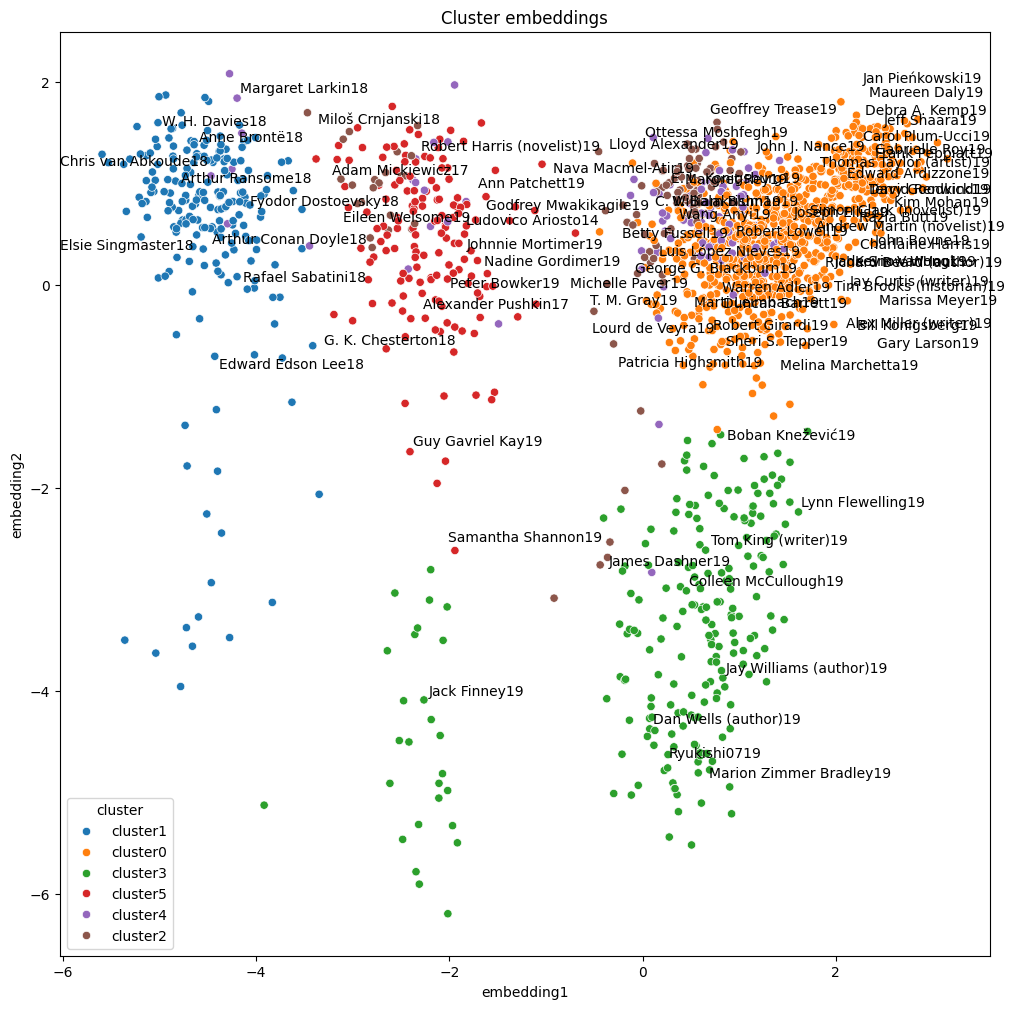

In [364]:
plot_clusters("cluster")

In [365]:
from sklearn import metrics
metrics.adjusted_rand_score(plot_df.continent, plot_df.cluster)

AttributeError: 'DataFrame' object has no attribute 'continent'